In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train_features2.csv")
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,spelling_errors,grammar_errors,punctuation_marks,text_length,sent_count,...,smog_score,stop_words,lexical_types,clauses_prop,sub_clauses_prop,verb_phrases_prop,noun_phrases_prop,chars_per_word,words_per_sentence,sybl_per_sentence
0,0013cc385424,007ACE74B050,hi i am isaac i am going to be writing about h...,Lead,Adequate,7,2,9,325,3.0,...,7.793538,43,43,0.039474,0.000000,0.0,0.105263,3.571429,23.333333,27.00
1,9704a709b505,007ACE74B050,on my perspective i think that the face is a n...,Position,Adequate,4,2,4,214,2.0,...,10.125757,27,30,0.042553,0.021277,0.0,0.127660,4.047619,21.000000,26.50
2,c22adee811b6,007ACE74B050,i think that the face is a natural landlord be...,Claim,Adequate,2,1,0,105,1.0,...,11.208143,13,20,0.045455,0.045455,0.0,0.136364,4.047619,21.000000,27.00
3,a10d361e54e4,007ACE74B050,if life wa on mar we would know by now the rea...,Evidence,Adequate,11,3,13,374,4.0,...,9.516145,46,49,0.047059,0.035294,0.0,0.058824,3.815789,19.000000,24.75
4,db3e453ec4e2,007ACE74B050,people thought that the face wa formed by alie...,Counterclaim,Adequate,2,1,1,100,1.0,...,3.129100,10,16,0.052632,0.052632,0.0,0.052632,4.555556,18.000000,20.00


In [3]:
df.shape

(36765, 28)

In [3]:
df.dtypes

discourse_id                object
essay_id                    object
discourse_text              object
discourse_type              object
discourse_effectiveness     object
spelling_errors              int64
grammar_errors               int64
punctuation_marks            int64
text_length                  int64
sent_count                 float64
word_count                 float64
sybl_count                 float64
char_count                 float64
polysyblword_count         float64
dalechall_score            float64
flesch_score               float64
fleschkincaid_score        float64
gunningfog_score           float64
smog_score                 float64
stop_words                   int64
lexical_types                int64
clauses_prop               float64
sub_clauses_prop           float64
verb_phrases_prop          float64
noun_phrases_prop          float64
chars_per_word             float64
words_per_sentence         float64
sybl_per_sentence          float64
dtype: object

In [4]:
df.discourse_type.value_counts()

Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: discourse_type, dtype: int64

## Modelos 

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import xgboost as xgb

In [6]:
df2 = df.drop(["discourse_id","essay_id"], axis=1)

In [7]:
one_hot_encoded = pd.get_dummies(df['discourse_type'], drop_first=True)
df2 = pd.concat([df2, one_hot_encoded], axis=1)
df2.head()

,discourse_text,discourse_type,discourse_effectiveness,spelling_errors,grammar_errors,punctuation_marks,text_length,sent_count,word_count,sybl_count,...,noun_phrases_prop,chars_per_word,words_per_sentence,sybl_per_sentence,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal
0,hi i am isaac i am going to be writing about h...,Lead,Adequate,7,2,9,325,3.0,70.0,81.0,...,0.105263,3.571429,23.333333,27.00,0,0,0,1,0,0
1,on my perspective i think that the face is a n...,Position,Adequate,4,2,4,214,2.0,42.0,53.0,...,0.127660,4.047619,21.000000,26.50,0,0,0,0,1,0
2,i think that the face is a natural landlord be...,Claim,Adequate,2,1,0,105,1.0,21.0,27.0,...,0.136364,4.047619,21.000000,27.00,0,0,0,0,0,0
3,if life wa on mar we would know by now the rea...,Evidence,Adequate,11,3,13,374,4.0,76.0,99.0,...,0.058824,3.815789,19.000000,24.75,0,0,1,0,0,0
4,people thought that the face wa formed by alie...,Counterclaim,Adequate,2,1,1,100,1.0,18.0,20.0,...,0.052632,4.555556,18.000000,20.00,0,1,0,0,0,0


In [9]:
labels = {
    'Ineffective': 0,
    'Adequate': 1,
    'Effective': 2
}

X = df2.drop(["discourse_effectiveness"], axis=1)
y = df2['discourse_effectiveness'].map(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
types = ['Evidence', 'Claim', 'Position', 'Concluding Statement', 'Lead', 'Counterclaim', 'Rebuttal']
maxlen = [3896, 641, 517, 1454, 1700, 1282, 944]
max_words = [696, 117, 99, 259, 316, 217, 175]

### Red Neuronal Convolucional

In [73]:
discourse_type = 'Rebuttal'

In [74]:
X_train_type = X_train[X_train.discourse_type == discourse_type].drop('discourse_type', axis=1)
y_train_type = y_train[X_train.discourse_type == discourse_type]

X_test_type = X_test[X_test.discourse_type == discourse_type].drop('discourse_type', axis=1)
y_test_type = y_test[X_test.discourse_type == discourse_type]

print(df2[df2.discourse_type == discourse_type].discourse_effectiveness.value_counts(normalize=True), "\n")
print(df2[df2.discourse_type == discourse_type].discourse_effectiveness.value_counts())
discourse_type = discourse_type.replace(' ', '')

Adequate       0.557074
Effective      0.273312
Ineffective    0.169614
Name: discourse_effectiveness, dtype: float64 

Adequate       693
Effective      340
Ineffective    211
Name: discourse_effectiveness, dtype: int64


In [75]:
maxlen = int(X_train_type["text_length"].max())
max_words = int(X_train_type['word_count'].max())

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_type['discourse_text'])
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_type['discourse_text']), maxlen=maxlen)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_type['discourse_text']), maxlen=maxlen)

tokenizer_json = tokenizer.to_json()
with open('models/tokenizer_' + discourse_type + '.json', 'w', encoding='utf-8') as json_file:
    json_file.write(tokenizer_json)

maxlen, max_words

(944, 175)

In [85]:
checkpoint = ModelCheckpoint(
    'models/conv_' + discourse_type + '.h5',
     monitor='val_loss',
     save_best_only=True,
     mode='min',
     verbose=1
)

early_stopping_train = EarlyStopping(
    monitor='accuracy',
    min_delta=0.01,
    patience=5,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10
) 


early_stopping_test = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10
) 

In [86]:
for conv_l2 in [0.005, 0.0005, 0.0001]:
    for lr in [0.01, 0.005, 0.001]:
        text_input = Input(shape=(maxlen,))

        embedding = Embedding(input_dim=max_words, output_dim=50, input_length=maxlen)(text_input)

        conv1d_1 = Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(conv_l2))(embedding)
        #conv1d_2 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(conv_l2))(conv1d_1)
        pooling = GlobalMaxPooling1D()(conv1d_1)

        hidden_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(pooling)
        hidden_2 = Dense(10, activation='relu', kernel_regularizer=l2(0.01))(hidden_1)

        output = Dense(3, activation='softmax')(hidden_2)

        model_conv = Model(inputs=text_input, outputs=output)
        model_conv.compile(optimizer=Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        print("\n\nlr =", lr)
        print("l2 =", conv_l2)

        model_conv.fit(
            X_train_seq, y_train_type,
            epochs=40,
            batch_size=128,
            validation_data=(X_test_seq, y_test_type),
            callbacks=[checkpoint, early_stopping_train, early_stopping_test]
        )



lr = 0.01
l2 = 0.005
Epoch 1/40
8/8 [==============================] - ETA: 0s - loss: 2.3923 - accuracy: 0.3461
Epoch 1: val_loss improved from inf to 2.26349, saving model to models\conv_Rebuttal.h5
8/8 [==============================] - 4s 422ms/step - loss: 2.3923 - accuracy: 0.3461 - val_loss: 2.2635 - val_accuracy: 0.3478
Epoch 2/40
8/8 [==============================] - ETA: 0s - loss: 2.1806 - accuracy: 0.3290
Epoch 2: val_loss improved from 2.26349 to 2.06938, saving model to models\conv_Rebuttal.h5
8/8 [==============================] - 3s 406ms/step - loss: 2.1806 - accuracy: 0.3290 - val_loss: 2.0694 - val_accuracy: 0.3281
Epoch 3/40
8/8 [==============================] - ETA: 0s - loss: 2.0003 - accuracy: 0.3512
Epoch 3: val_loss improved from 2.06938 to 1.90273, saving model to models\conv_Rebuttal.h5
8/8 [==============================] - 3s 417ms/step - loss: 2.0003 - accuracy: 0.3512 - val_loss: 1.9027 - val_accuracy: 0.5771
Epoch 4/40
8/8 [==========================



lr = 0.005
l2 = 0.005
Epoch 1/40
8/8 [==============================] - ETA: 0s - loss: 2.3677 - accuracy: 0.4319
Epoch 1: val_loss did not improve from 1.04604
8/8 [==============================] - 5s 466ms/step - loss: 2.3677 - accuracy: 0.4319 - val_loss: 2.2350 - val_accuracy: 0.5850
Epoch 2/40
8/8 [==============================] - ETA: 0s - loss: 2.1470 - accuracy: 0.5499
Epoch 2: val_loss did not improve from 1.04604
8/8 [==============================] - 3s 396ms/step - loss: 2.1470 - accuracy: 0.5499 - val_loss: 2.0279 - val_accuracy: 0.5850
Epoch 3/40
8/8 [==============================] - ETA: 0s - loss: 1.9576 - accuracy: 0.5499
Epoch 3: val_loss did not improve from 1.04604
8/8 [==============================] - 3s 387ms/step - loss: 1.9576 - accuracy: 0.5499 - val_loss: 1.8486 - val_accuracy: 0.5850
Epoch 4/40
8/8 [==============================] - ETA: 0s - loss: 1.7924 - accuracy: 0.5499
Epoch 4: val_loss did not improve from 1.04604
8/8 [============================

KeyboardInterrupt: 

In [59]:
probs_conv = model_conv.predict(X_test_seq)
predictions_conv = np.argmax(probs_conv, axis=1)
print(classification_report(y_test_type, predictions_conv, zero_division=np.nan))

15/15 [==============================] - 1s 42ms/step
              precision    recall  f1-score   support

           0        nan      0.00       nan        65
           1       0.57      1.00      0.73       267
           2        nan      0.00       nan       137

    accuracy                           0.57       469
   macro avg       0.57      0.33      0.73       469
weighted avg       0.57      0.57      0.73       469



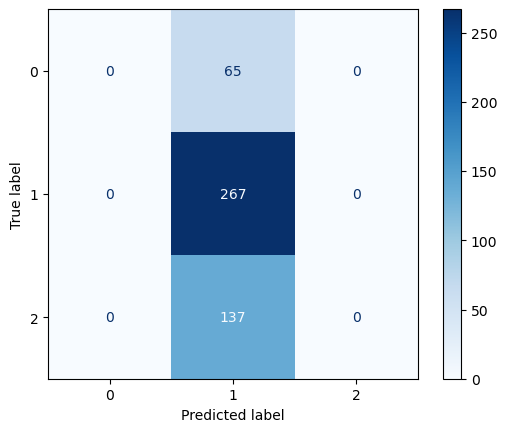

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test_type, predictions_conv, cmap='Blues')
plt.show()

### Red Neuronal con TF-IDF

In [61]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
def remove_stop_words(text):
    removed_stop_words = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return removed_stop_words

In [62]:
X_train_text = X_train_type['discourse_text'].apply(remove_stop_words)
X_test_text = X_test_type['discourse_text'].apply(remove_stop_words)

In [63]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

In [64]:
tfidf_input = Input(shape=(X_train_tfidf.shape[1],), name='tfidf_input')

dense_tfidf = Dense(128, activation='relu', name='dense_tfidf', kernel_regularizer=l2(0.01))(tfidf_input)

hidden_layer = Dense(64, activation='relu', name='hidden_layer', kernel_regularizer=l2(0.01))(dense_tfidf)

output_layer = Dense(3, activation='softmax', name='output')(hidden_layer)

model_tfidf = Model(inputs=[tfidf_input], outputs=output_layer)
model_tfidf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_tfidf.summary()

model_tfidf.fit(
    [X_train_tfidf], y_train_type,
    epochs=20,
    batch_size=128,
    validation_data=([X_test_tfidf], y_test_type)
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tfidf_input (InputLayer)    [(None, 4607)]            0         
                                                                 
 dense_tfidf (Dense)         (None, 128)               589824    
                                                                 
 hidden_layer (Dense)        (None, 64)                8256      
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 598275 (2.28 MB)
Trainable params: 598275 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 2s 48ms/step - loss: 3.2985 - accuracy: 0.5220 - val_loss: 2.2483 - val_accuracy: 0.5693
Epoch 2/20
15/

In [65]:
probs_tfidf = model_tfidf.predict(X_test_tfidf)
predictions_tfidf = np.argmax(probs_tfidf, axis=1)
print(classification_report(y_test_type, predictions_tfidf, zero_division=np.nan))

15/15 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0        nan      0.00       nan        65
           1       0.67      0.85      0.75       267
           2       0.65      0.61      0.63       137

    accuracy                           0.66       469
   macro avg       0.66      0.49      0.69       469
weighted avg       0.66      0.66      0.71       469



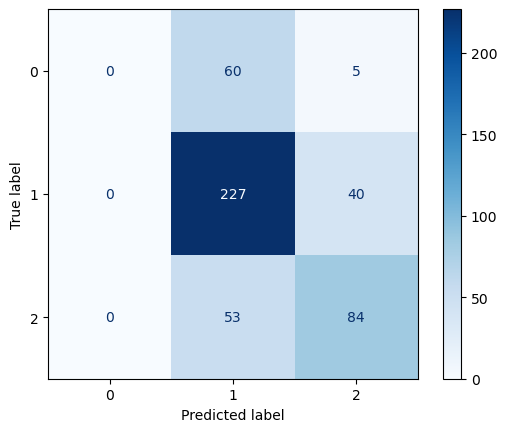

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test_type, predictions_tfidf, cmap='Blues')
plt.show()

### XGBoost Stacking

In [67]:
X_train_features = X_train_type.drop("discourse_text", axis=1)
X_test_features = X_test_type.drop("discourse_text", axis=1)

In [68]:
X_train_features[['prob_0_conv', 'prob_1_conv', 'prob_2_conv']] = model_conv.predict(X_train_seq)
X_test_features[['prob_0_conv', 'prob_1_conv', 'prob_2_conv']] = probs_conv

X_train_features[['prob_0_tfidf', 'prob_1_tfidf', 'prob_2_tfidf']] = model_tfidf.predict(X_train_tfidf)
X_test_features[['prob_0_tfidf', 'prob_1_tfidf', 'prob_2_tfidf']] = probs_tfidf

57/57 [==============================] - 0s 3ms/step


In [69]:
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    seed=42,
    learning_rate=0.05,
    max_bins=400,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)
model_xgb.fit(X_train_features, y_train_type)
predictions_xgb = model_xgb.predict(X_test_features)
print(classification_report(y_train_type, model_xgb.predict(X_train_features), zero_division=np.nan))
print(classification_report(y_test_type, predictions_xgb, zero_division=np.nan))

C:\Users\osjom\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:00:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_bins" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.76      0.49      0.60       299
           1       0.82      0.91      0.86       977
           2       0.91      0.89      0.90       546

    accuracy                           0.84      1822
   macro avg       0.83      0.77      0.79      1822
weighted avg       0.84      0.84      0.83      1822

              precision    recall  f1-score   support

           0       0.46      0.29      0.36        65
           1       0.69      0.76      0.73       267
           2       0.64      0.63      0.63       137

    accuracy                           0.66       469
   macro avg       0.60      0.56      0.57       469
weighted avg       0.65      0.66      0.65       469



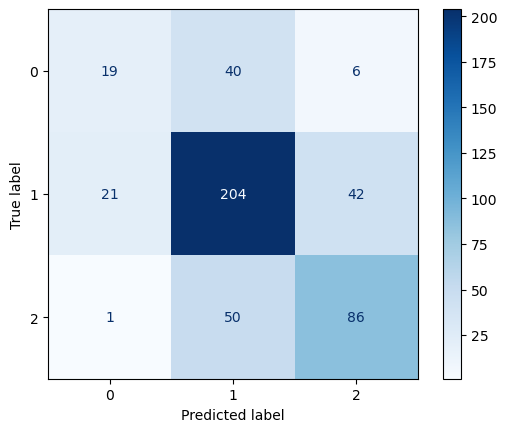

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test_type, predictions_xgb, cmap='Blues')
plt.show()